Hello, test

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install torchsummary

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import time
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchsummary import summary
import torchvision
from torchvision import datasets, transforms
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# Setup paths
# TRAIN = "/kaggle/input/birds23sp/birds/train/"
TRAIN = "/kaggle/input/birds-split/birds/train/"
VALID = "/kaggle/input/birds-split/birds/val"
TEST = "/kaggle/input/birds23sp/birds/test/"
checkpoints = "/kaggle/working/checkpoints/"
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

classes = os.listdir(TRAIN)
print("Total Classes: ",len(classes))
#Counting total train, valid & test images
train_count = 0

for _class in classes:
    train_count += len(os.listdir(TRAIN + _class))

print("Total train images: ",train_count)

#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Total Classes:  555
Total train images:  30629


In [2]:
# wrapper to apply transformations (so augment after split)
class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [3]:
def get_bird_data(augmentation=0):
    transform_train = transforms.Compose([
        transforms.RandomOrder([
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(),    
            transforms.RandomVerticalFlip(p=0.1)
        ]),
        transforms.RandomApply(
            torch.nn.ModuleList([
                transforms.ColorJitter()
            ]), p=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    transform_valid = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    transform_test = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    # apply transformations after split (so valid set isn't augmented)
#     fulldataset = datasets.ImageFolder(root=TRAIN, transform=None)
#     trainsize = int(0.8 * len(fulldataset))
#     validationsize = len(fulldataset) - trainsize
#     trainset_pretrans, validset_pretrans = torch.utils.data.random_split(fulldataset, [trainsize, validationsize])
    
    trainset = datasets.ImageFolder(root=TRAIN, transform=transform_train)
    validset = datasets.ImageFolder(root=VALID, transform=transform_valid)
    # apply transformations
#     trainset = TransformDataset(trainset_pretrans, transform=transform_train)
#     validset = TransformDataset(validset_pretrans, transform=transform_valid)
    testset = datasets.ImageFolder(root=TEST, transform=transform_test)
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
    validloader = torch.utils.data.DataLoader(validset, batch_size=64, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
    classes = open("/kaggle/input/birds23sp/birds/names.txt").read().strip().split("\n")
#     class_to_idx = fulldataset.class_to_idx
    class_to_idx = trainset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}

    return {'train': trainloader, 'val': validloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data()
dataset_sizes = {'train': len(data['train'].dataset), 'val': len(data['val'].dataset)}
print(len(data['to_name']))
print(dataset_sizes['train'])
print(dataset_sizes['val'])

555
30629
7933


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 224, 224])


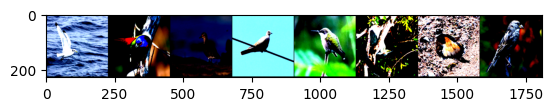

Labels:Black-legged Kittiwake (Adult), Painted Bunting (Adult Male), Black-bellied Plover (Nonbreeding/juvenile), Eurasian Collared-Dove, Ruby-throated Hummingbird (Female, immature), Black-crowned Night-Heron (Adult),  Killdeer, House Sparrow (Female/Juvenile)


In [4]:
dataiter = iter(data['train'])
images, labels = next(dataiter)
images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ', '.join('%9s' % data['to_name'][labels[j].item()] for j in range(8)))

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    losses = [[], []]
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        # Each epoch has a training and validatioin phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in data[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                losses[0 if phase == 'train' else 1].append(loss.item())
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                print('deep copying model')
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, losses

In [6]:
# model, 
model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)
# model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
# freeze all base layers first
# for param in model.features.parameters():
#     param.requires_grad = False

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2),
    torch.nn.Linear(1280, 555)
)

model = model.to(device)

summary(model, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|ââââââââââ| 82.7M/82.7M [00:00<00:00, 226MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              SiLU-3         [-1, 24, 112, 112]               0
            Conv2d-4         [-1, 24, 112, 112]           5,184
       BatchNorm2d-5         [-1, 24, 112, 112]              48
              SiLU-6         [-1, 24, 112, 112]               0
   StochasticDepth-7         [-1, 24, 112, 112]               0
       FusedMBConv-8         [-1, 24, 112, 112]               0
            Conv2d-9         [-1, 24, 112, 112]           5,184
      BatchNorm2d-10         [-1, 24, 112, 112]              48
             SiLU-11         [-1, 24, 112, 112]               0
  StochasticDepth-12         [-1, 24, 112, 112]               0
      FusedMBConv-13         [-1, 24, 112, 112]               0
           Conv2d-14           [-1, 96,

In [7]:
criterion = nn.CrossEntropyLoss()

# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model, losses = train_model(model, criterion, optimizer, scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 3.4974 Acc: 0.2844
val Loss: 1.6777 Acc: 0.5514
deep copying model

Epoch 1/19
----------
train Loss: 1.3368 Acc: 0.6375
val Loss: 1.1137 Acc: 0.6827
deep copying model

Epoch 2/19
----------
train Loss: 0.8503 Acc: 0.7598
val Loss: 0.9416 Acc: 0.7242
deep copying model

Epoch 3/19
----------
train Loss: 0.6092 Acc: 0.8250
val Loss: 0.8701 Acc: 0.7473
deep copying model

Epoch 4/19
----------
train Loss: 0.4615 Acc: 0.8631
val Loss: 0.8135 Acc: 0.7705
deep copying model

Epoch 5/19
----------
train Loss: 0.2560 Acc: 0.9330
val Loss: 0.6659 Acc: 0.8046
deep copying model

Epoch 6/19
----------
train Loss: 0.2047 Acc: 0.9486
val Loss: 0.6436 Acc: 0.8103
deep copying model

Epoch 7/19
----------
train Loss: 0.1811 Acc: 0.9557
val Loss: 0.6381 Acc: 0.8138
deep copying model

Epoch 8/19
----------
train Loss: 0.1575 Acc: 0.9636
val Loss: 0.6375 Acc: 0.8151
deep copying model

Epoch 9/19
----------
train Loss: 0.1451 Acc: 0.9658
val Loss: 0.6358 Acc: 0.8176


In [8]:
torch.save(model, checkpoints+'model.pt')

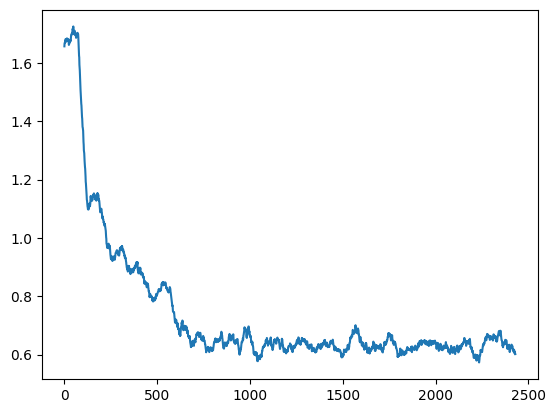

In [9]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')
plt.plot(smooth(losses[1],50))

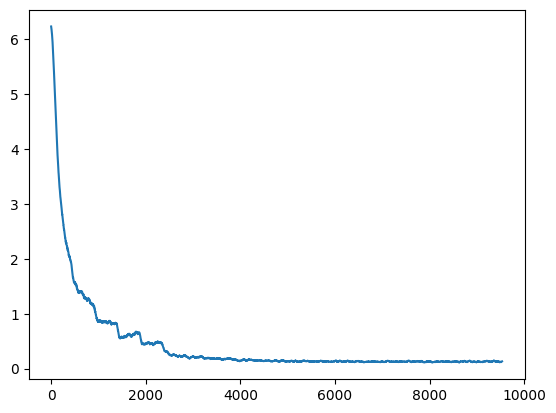

In [10]:
plt.plot(smooth(losses[0], 50))

In [11]:
def predict(net, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], data['to_class'][predicted.item()]))
    out.close()

In [12]:
predict(model, data['test'], checkpoints + "preds.csv")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
